In [1]:
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import geodatasets
from shapely import box
from shapely.geometry import Polygon,box,Point


### 1. Cargar shapefile y crear grilla 

In [26]:
chile = gp.read_file('Regiones/Regional.shp')

<Axes: >

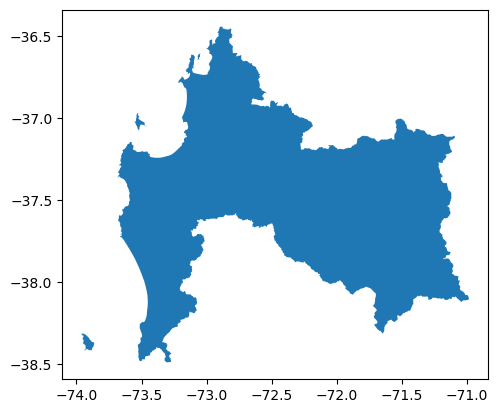

In [27]:
chile_bb = chile[chile['Region'] == 'Región del Bío-Bío']

chile_bb = chile_bb.to_crs(epsg=4326)
chile_bb.crs

# graficar solo region del bio-bio

chile_bb.plot()

In [29]:
xmin, ymin, xmax, ymax= chile_bb.total_bounds

## real cell dimensions
cell_width  = 0.0817750
cell_height = 0.0321233

grid_cells = []
for x0 in np.arange(xmin, xmax+cell_width, cell_width ):
    for y0 in np.arange(ymin, ymax+cell_height, cell_height):
        x1 = x0-cell_width
        y1 = y0+cell_height
        new_cell = box(x0, y0, x1, y1)
        if new_cell.intersects(chile_bb["geometry"].all()):
            grid_cells.append(new_cell)
        else:
            pass

In [30]:
cell_df = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")

<Axes: >

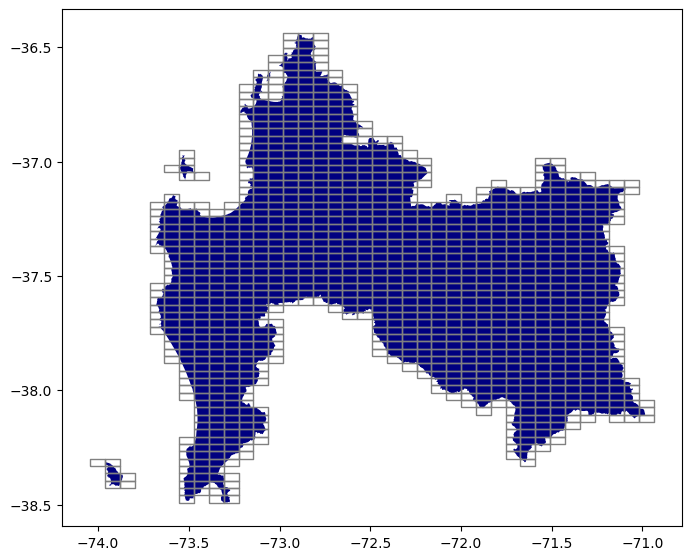

In [31]:
ax = chile_bb.plot(markersize=.1, figsize=(8, 8), cmap='jet')
cell_df.plot(ax=ax,facecolor="none", edgecolor='grey')

In [32]:
chile_bb.to_file("biobio_geodf.shp")
cell_df.to_file("cuadrillas.shp")

### 2. Cargar datos de CONAF y asignar cada incendio a una cuadrilla

In [73]:
df_conaf = pd.read_excel("datos_conaf.xlsx")

In [74]:
df_conaf['Point'] = df_conaf.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)

In [75]:
def find_containing_box(point, boxes):
    for index, box in enumerate(boxes):
        if box.contains(point):
            return index
    return None

df_conaf['Cuadrilla'] = df_conaf['Point'].apply(find_containing_box, args=(cell_df['geometry'],))


In [76]:
df_conaf

,Unnamed: 0,Región,Provincia,Comuna,Nombre incendio,UTM E,UTM N,Huso,Causa general,Causa específica,...,Humedad,Exposición,Dirección viento,Velocidad viento,Topografía,Pendiente,Lat,Lon,Point,Cuadrilla
0,0,Biobío,Biobio,Nacimiento,TRALPENES Y OTROS,711129 E,5845313 S,18H,Faenas forestales,1.1.22. Otros incendios por faenas forestales ...,...,53.0,NaN,S,10.0,NaN,%,-37.515000,-72.611111,POINT (-72.6111111111111 -37.515),495.0
1,1,Biobío,Concepción,Coronel,ESCUADRON,666889 E,5909655 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,86.0,NaN,S,3.0,NaN,%,-36.944444,-73.125833,POINT (-73.12583333333333 -36.94444444444444),294.0
2,2,Biobío,Biobio,Quilaco,BRETANA,756360 E,5821179 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,70.0,NaN,S,5.0,NaN,%,-37.720833,-72.091389,POINT (-72.09138888888889 -37.72083333333334),677.0
3,3,Biobío,Concepción,Coronel,ESCUADRON,665097 E,5909157 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,77.0,NaN,SW,15.0,NaN,%,-36.949167,-73.145833,POINT (-73.14583333333334 -36.94916666666666),248.0
4,4,Biobío,Arauco,Cañete,MAQUEHUA,654518 E,5814058 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,86.0,NaN,N,10.0,NaN,%,-37.807778,-73.244722,POINT (-73.24472222222222 -37.80777777777777),186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10811,10811,Biobío,Biobio,Los Angeles,DUQUECO IV,732049 E,5845681 S,18H,Quema de desechos,1.8.1. Quema de basuras desechos vegetales u ...,...,55.6,Plano,Calmo,0.0,Suave,0 %,-37.506667,-72.374722,POINT (-72.37472222222222 -37.50666666666667),590.0
10812,10812,Biobío,Arauco,Curanilahue,CURANILAHUE (TRABAJO SOCIAL),639530 E,5849276 S,18H,Incendios de causa desconocida,4.1.2. No determinada (la causa no es investig...,...,55.0,Plano,S,10.0,Suave,0 %,-37.492778,-73.421667,POINT (-73.42166666666667 -37.49277777777778),115.0
10813,10813,Biobío,Concepción,Hualqui,HUALQUI (PARTICULAR) (TRABAJO SOCIAL),682738 E,5889567 S,18H,Incendios de causa desconocida,4.1.2. No determinada (la causa no es investig...,...,50.0,Plano,SW,25.0,Suave,0 %,-37.122500,-72.943056,POINT (-72.94305555555556 -37.1225),361.0
10814,10814,Biobío,Biobio,Los Angeles,LOS MAITENES LOTE A PART,735085 E,5861052 S,18H,Quema de desechos,1.8.5. Quema ilegal para limpia de caminos ca...,...,68.0,Plano,S,11.0,Suave,0 %,-37.367500,-72.345278,POINT (-72.34527777777777 -37.3675),595.0


### 4. Transformar fechas a datetime para crear las semanas de observación

In [77]:
# transformar fecha "19-nov-2018 11:58" a datetime

from datetime import datetime

max_date = '31-may-2022 17:05'

# rellenar datos faltantes con max_date para la columna control

df_conaf['Control'] = df_conaf['Control'].fillna(max_date)

# Define un mapeo de nombres de meses a números de mes
meses = {'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
         'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'}

# Función para convertir una fecha en formato 'dd-mes-año hora:minuto' a formato datetime
def convertir_a_datetime(fecha_str):
    partes = fecha_str.split('-')
    dia = int(partes[0])
    mes = meses[partes[1].lower()]
    ano = int(partes[2].split()[0])
    hora, minuto = map(int, partes[2].split()[1].split(':'))
    return datetime(ano, datetime.strptime(mes, '%b').month, dia, hora, minuto)

# Aplica la función a la columna 'fecha' y crea una nueva columna 'fecha_datetime'

df_conaf['Inicio'] = df_conaf['Inicio'].apply(convertir_a_datetime)
df_conaf['Control'] = df_conaf['Control'].apply(convertir_a_datetime)


In [84]:
df_conaf['Semana Inicio'] = (df_conaf['Inicio'] - df_conaf['Inicio'].min()).dt.days // 7 + 1

df_conaf['Semana Control'] = (df_conaf['Control'] - df_conaf['Inicio'].min()).dt.days // 7 + 1


In [85]:
df_conaf

,Unnamed: 0,Región,Provincia,Comuna,Nombre incendio,UTM E,UTM N,Huso,Causa general,Causa específica,...,Dirección viento,Velocidad viento,Topografía,Pendiente,Lat,Lon,Point,Cuadrilla,Semana Inicio,Semana Control
0,0,Biobío,Biobio,Nacimiento,TRALPENES Y OTROS,711129 E,5845313 S,18H,Faenas forestales,1.1.22. Otros incendios por faenas forestales ...,...,S,10.0,NaN,%,-37.515000,-72.611111,POINT (-72.6111111111111 -37.515),495.0,12,12
1,1,Biobío,Concepción,Coronel,ESCUADRON,666889 E,5909655 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,S,3.0,NaN,%,-36.944444,-73.125833,POINT (-73.12583333333333 -36.94444444444444),294.0,12,12
2,2,Biobío,Biobio,Quilaco,BRETANA,756360 E,5821179 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,S,5.0,NaN,%,-37.720833,-72.091389,POINT (-72.09138888888889 -37.72083333333334),677.0,12,12
3,3,Biobío,Concepción,Coronel,ESCUADRON,665097 E,5909157 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,SW,15.0,NaN,%,-36.949167,-73.145833,POINT (-73.14583333333334 -36.94916666666666),248.0,11,11
4,4,Biobío,Arauco,Cañete,MAQUEHUA,654518 E,5814058 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,...,N,10.0,NaN,%,-37.807778,-73.244722,POINT (-73.24472222222222 -37.80777777777777),186.0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10811,10811,Biobío,Biobio,Los Angeles,DUQUECO IV,732049 E,5845681 S,18H,Quema de desechos,1.8.1. Quema de basuras desechos vegetales u ...,...,Calmo,0.0,Suave,0 %,-37.506667,-72.374722,POINT (-72.37472222222222 -37.50666666666667),590.0,192,192
10812,10812,Biobío,Arauco,Curanilahue,CURANILAHUE (TRABAJO SOCIAL),639530 E,5849276 S,18H,Incendios de causa desconocida,4.1.2. No determinada (la causa no es investig...,...,S,10.0,Suave,0 %,-37.492778,-73.421667,POINT (-73.42166666666667 -37.49277777777778),115.0,176,176
10813,10813,Biobío,Concepción,Hualqui,HUALQUI (PARTICULAR) (TRABAJO SOCIAL),682738 E,5889567 S,18H,Incendios de causa desconocida,4.1.2. No determinada (la causa no es investig...,...,SW,25.0,Suave,0 %,-37.122500,-72.943056,POINT (-72.94305555555556 -37.1225),361.0,171,171
10814,10814,Biobío,Biobio,Los Angeles,LOS MAITENES LOTE A PART,735085 E,5861052 S,18H,Quema de desechos,1.8.5. Quema ilegal para limpia de caminos ca...,...,S,11.0,Suave,0 %,-37.367500,-72.345278,POINT (-72.34527777777777 -37.3675),595.0,193,193


### 5. tomar las cuadriculas y hacer un dataframe con cada una de ellas como fila

In [129]:
# tomar las cuadriculas y hacer un dataframe con cada una de ellas

df_cuadrillas = pd.DataFrame(cell_df['geometry'])

# renombrar columna geometry a cuadrilla

df_cuadrillas = df_cuadrillas.rename(columns={'geometry': 'Cuadrilla'})

# asignar un id a cada cuadrilla

df_cuadrillas['id'] = df_cuadrillas.index

#agregar una columna por cada semana

for i in range(1, 197):
    df_cuadrillas['Semana ' + str(i)] = 0




C:\Users\joaci\AppData\Local\Temp\ipykernel_7264\2367703862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas['Semana ' + str(i)] = 0
C:\Users\joaci\AppData\Local\Temp\ipykernel_7264\2367703862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas['Semana ' + str(i)] = 0
C:\Users\joaci\AppData\Local\Temp\ipykernel_7264\2367703862.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [132]:
# asignar 1 si la cuadrilla tiene un incendio en la semana

for index, row in df_conaf.iterrows():
    df_cuadrillas.loc[df_cuadrillas['id'] == row['Cuadrilla'], 'Semana ' + str(row['Semana Inicio'])] = 1

#quitar la columna cuadrilla

df_cuadrillas = df_cuadrillas.drop(columns=['Cuadrilla'])

In [133]:
df_cuadrillas

,id,Semana 1,Semana 2,Semana 3,Semana 4,Semana 5,Semana 6,Semana 7,Semana 8,Semana 9,...,Semana 187,Semana 188,Semana 189,Semana 190,Semana 191,Semana 192,Semana 193,Semana 194,Semana 195,Semana 196
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,1100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1101,1101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102,1102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1103,1103,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Primer modelo (? (No funciona)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = df_cuadrillas.drop('id', axis=1)
y = df_cuadrillas['id']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print('Precisión del modelo:', accuracy)

# Mostrar un informe de clasificación
print('Informe de clasificación:')
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.0
Informe de clasificación:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       1.0
          23       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       0.0
          26       0.00      0.00      0.00       0.0
          30       0.00      0.00      0.00       1.0
          31       0.00      0.00      0.00       1.0
          39       0.00      0.00      0.00       1.0
          41       0.00      0.00      0.00       0.0
          44       0.00      0.00      0.00       1.0
          49       0.00      0.00      0.00       1.0
          50       0.00      0.00      0.00       0.0
          51       0.00      0.00      0.00       1.0
          54       0.00      0.00      0.00       1.0
          56       0.00      

c:\Users\joaci\anaconda3\envs\envU\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaci\anaconda3\envs\envU\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaci\anaconda3\envs\envU\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\joaci\anaconda3\envs\env

In [ ]:
df_conaf.to_excel("conaf_cuadrillas.xlsx")